In [33]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from rism.core import FFTGrid
from rism.environment import *

## Basis function

In [125]:
def get_basis(r, center, width):
    res = cp.abs(r - center)
    area = res<width
    res[area] = - 1 / width * res[area] + 1
    res[~area] = 0
    return res.astype(CUPY_FLOAT)

In [126]:
grid = FFTGrid(x=[-10, 10, 256], y=[-10, 10, 256])
r = cp.sqrt(grid.x**2 + grid.y**2)

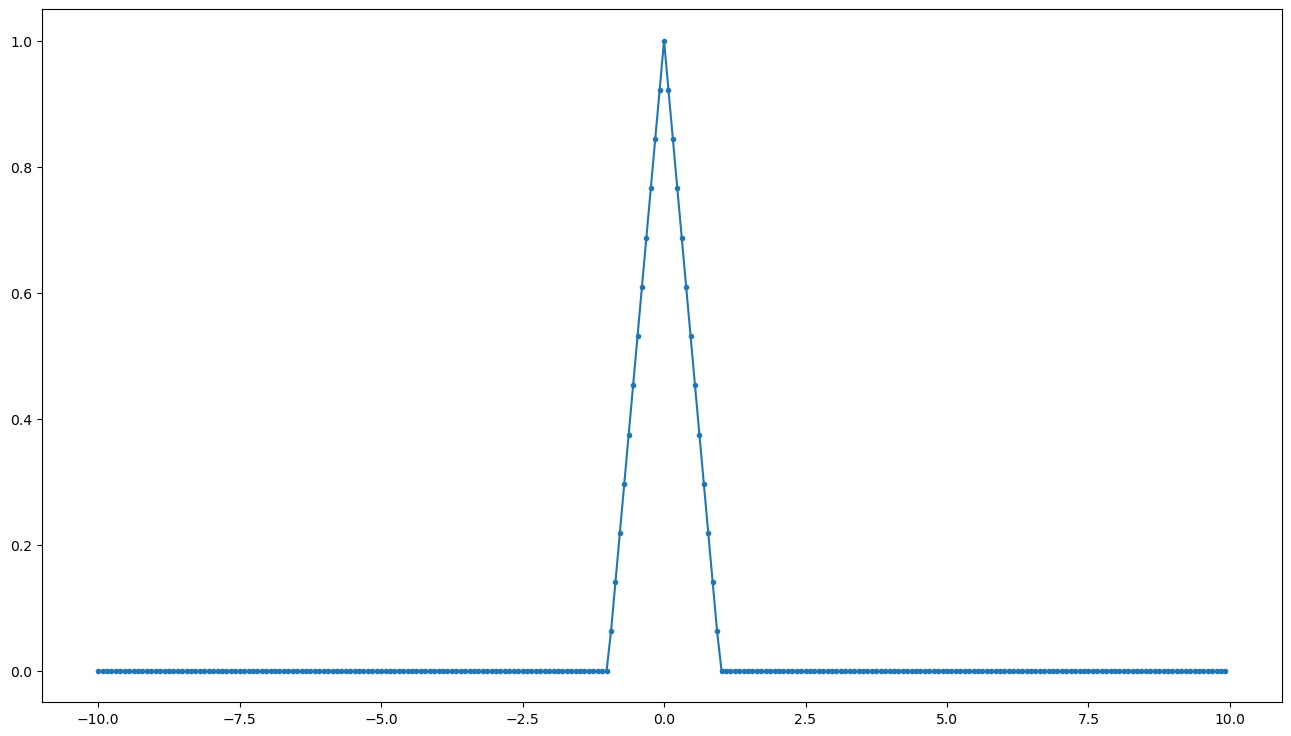

In [127]:
basis1 = get_basis(r, 0, 1.0)

fig, ax = plt.subplots(1, 1, figsize=[16, 9])
if True:
    half = grid.shape[1] // 2
    ax.plot(grid.x[:, half].get(), basis1[:, half].get(), '.-')
else:
    c = ax.contourf(grid.x.get(), grid.y.get(), basis1.get(), 50)
    fig.colorbar(c)

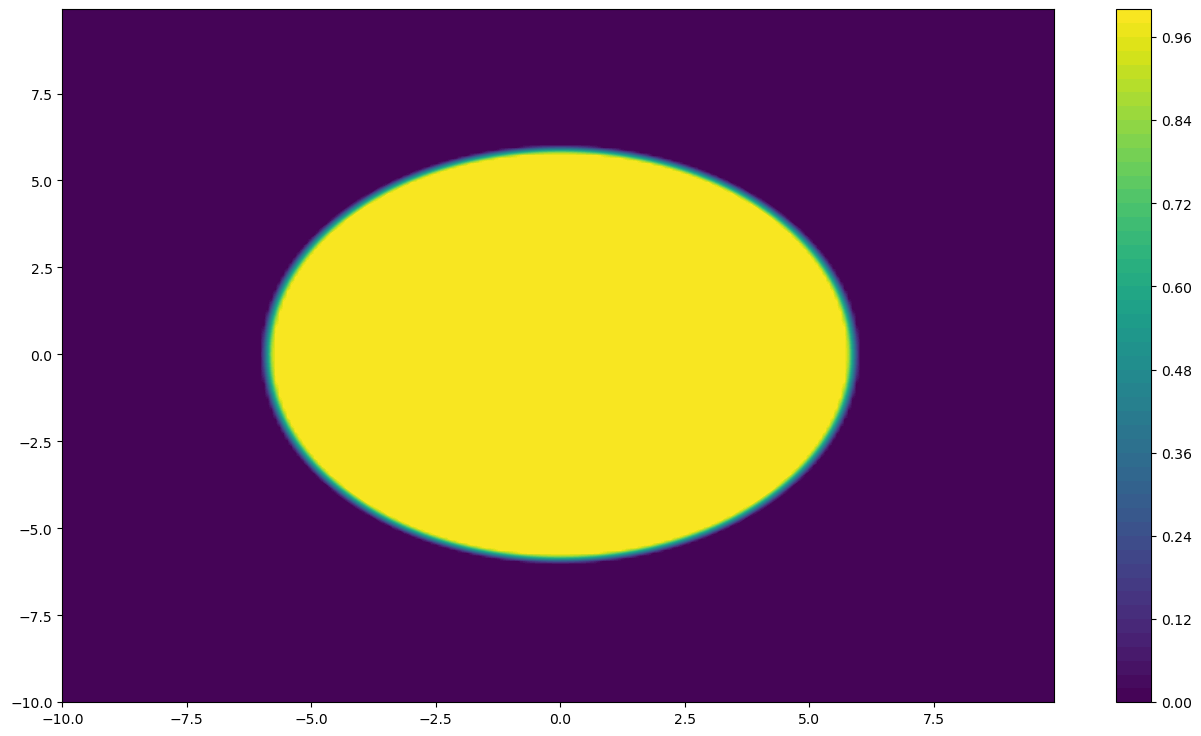

In [159]:
center = np.arange(0, 6, 0.25)
basis_set = [get_basis(r, i, 0.25) for i in center]
fig, ax = plt.subplots(1, 1, figsize=[16, 9])
basis_sum = grid.zeros_field()
for basis in basis_set:
    basis_sum += basis
c = ax.contourf(grid.x.get(), grid.y.get(), basis_sum.get(), 50)
fig.colorbar(c)

## Conjugate functions

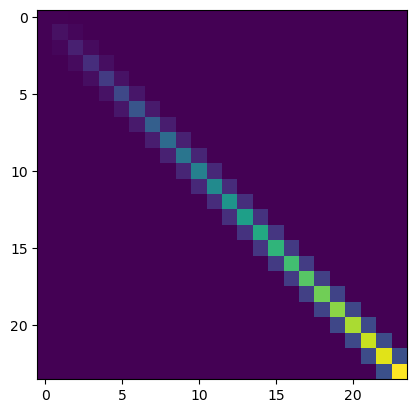

array([[ 2.07487717e-01, -2.69396864e-02,  5.35626383e-03,
        -1.21884618e-03,  2.88763171e-04, -6.94673145e-05,
         1.68421702e-05, -4.18695618e-06,  1.05689219e-06,
        -2.69337733e-07,  6.81935219e-08, -1.73460677e-08,
         4.46079484e-09, -1.15563970e-09,  2.99980568e-10,
        -7.73414943e-11,  1.99756808e-11, -5.19265620e-12,
         1.36173993e-12, -3.56103222e-13,  9.25583124e-14,
        -2.39905514e-14,  6.25552043e-15, -1.53614655e-15],
       [-2.69396883e-02,  2.84405574e-02, -5.65467309e-03,
         1.28675089e-03, -3.04850837e-04,  7.33374982e-05,
        -1.77804868e-05,  4.42022110e-06, -1.11577413e-06,
         2.84343145e-07, -7.19927442e-08,  1.83124573e-08,
        -4.70931605e-09,  1.22002297e-09, -3.16693172e-10,
         8.16503740e-11, -2.10885719e-11,  5.48195126e-12,
        -1.43760557e-12,  3.75942550e-13, -9.77149541e-14,
         2.53271237e-14, -6.60403002e-15,  1.62172886e-15],
       [ 5.35626383e-03, -5.65467309e-03,  1.36235850e

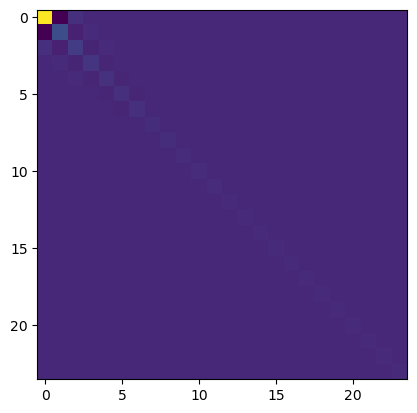

In [160]:
num_basis = len(basis_set)
conv_matrix = cp.zeros((num_basis, num_basis), CUPY_FLOAT)
for i in range(num_basis):
    for j in range(num_basis):
        conv_matrix[i, j] = (basis_set[i] * basis_set[j]).sum() 

plt.imshow(conv_matrix.get())
plt.show()

B = cp.linalg.inv(conv_matrix)
plt.imshow(B.get())
B

In [161]:
Q = []
for i in range(num_basis):
    cur_Q = grid.zeros_field()
    for j in range(num_basis):
        cur_Q += B[i, j] * basis_set[j]
    Q.append(cur_Q)

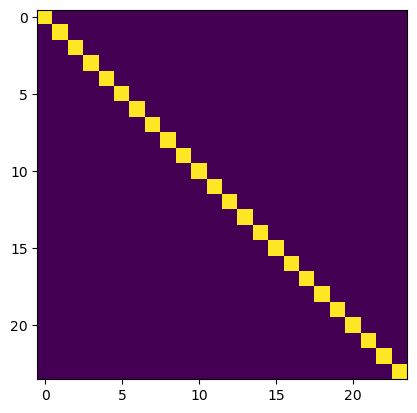

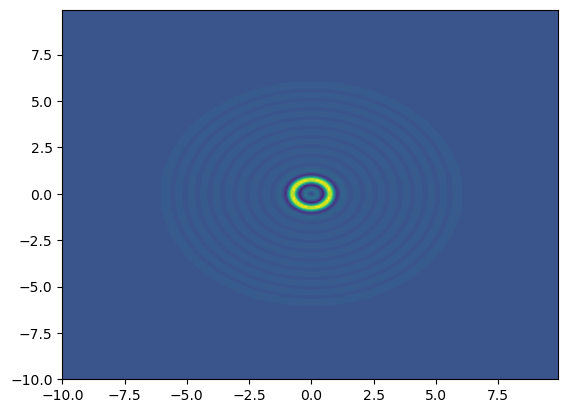

In [162]:
res = cp.zeros((num_basis, num_basis), CUPY_FLOAT)
for i in range(num_basis):
    for j in range(num_basis):
        res[i, j] = (Q[i] * basis_set[j]).sum() 
plt.imshow(res.get())
plt.show()
plt.contourf(grid.x.get(), grid.y.get(), Q[3].get(), 50)

## Decomposition

In [163]:
def get_conjugate_basis_set(basis_set):
    num_basis = len(basis_set)
    conv_matrix = cp.zeros((num_basis, num_basis), CUPY_FLOAT)
    for i in range(num_basis):
        for j in range(num_basis):
            conv_matrix[i, j] = (basis_set[i] * basis_set[j]).sum() 
    B = cp.linalg.inv(conv_matrix)
    conjugate_set = []
    for i in range(num_basis):
        Q = grid.zeros_field()
        for j in range(num_basis):
            Q += B[i, j] * basis_set[j]
        conjugate_set.append(Q)
    return conjugate_set

In [164]:
def get_target(r):
    return cp.exp(-(r-2)**2/0.05) + cp.exp(-r**2)

In [165]:
basis_set = [get_basis(r, i, 0.5) for i in np.arange(0, 6, 0.75)]
conjugate_set = get_conjugate_basis_set(basis_set)

target = get_target(r)
a = []
decomposed_res = grid.zeros_field()
for i in range(len(basis_set)):
    a.append((target*conjugate_set[i]).sum())
    decomposed_res += a[-1] * basis_set[i]

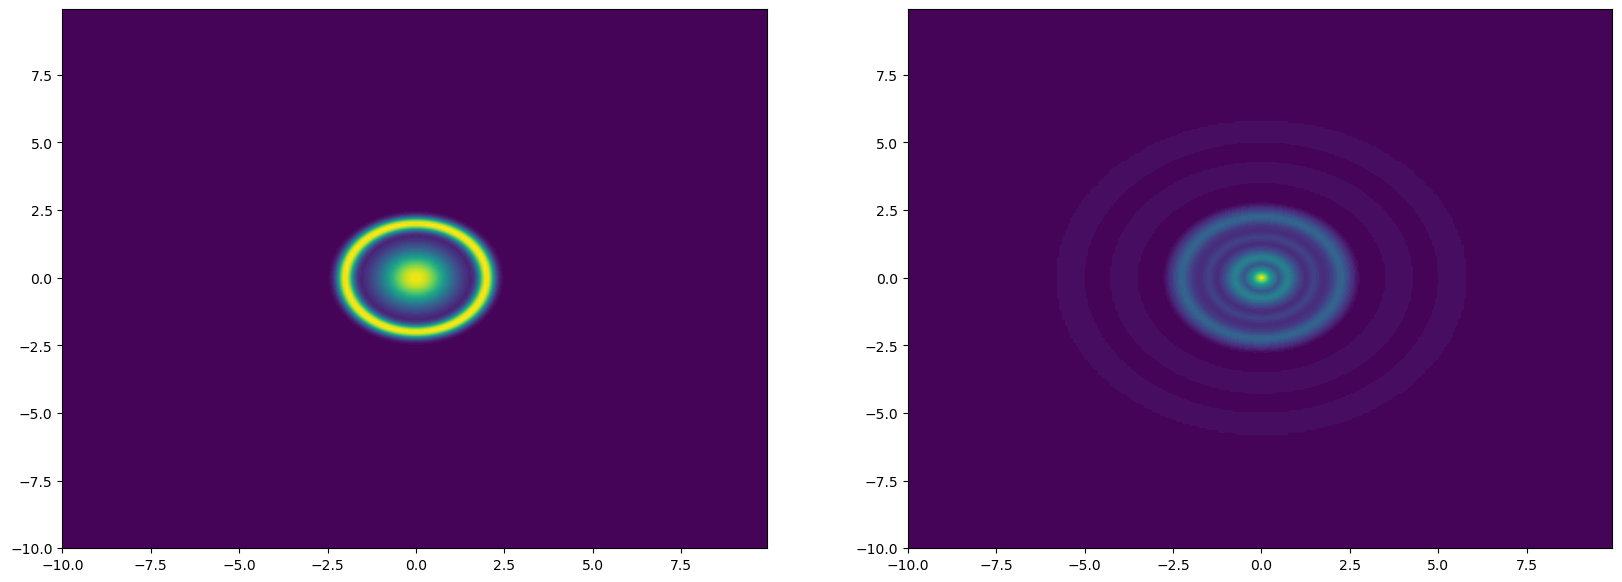

In [166]:
fig, ax = plt.subplots(1, 2, figsize=[20, 7])
ax[0].contourf(grid.x.get(), grid.y.get(), target.get(), 50)
ax[1].contourf(grid.x.get(), grid.y.get(), decomposed_res.get(), 50)

/tmp/ipykernel_3828088/153938653.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[cupy.array(seq)]`, which will result either in an error or a different result.
  ax[0].plot(grid.x[target_slice].get(), target[target_slice].get(), '.-')
/tmp/ipykernel_3828088/153938653.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[cupy.array(seq)]`, which will result either in an error or a different result.
  ax[1].plot(grid.x[target_slice].get(), decomposed_res[target_slice].get(), '.-')


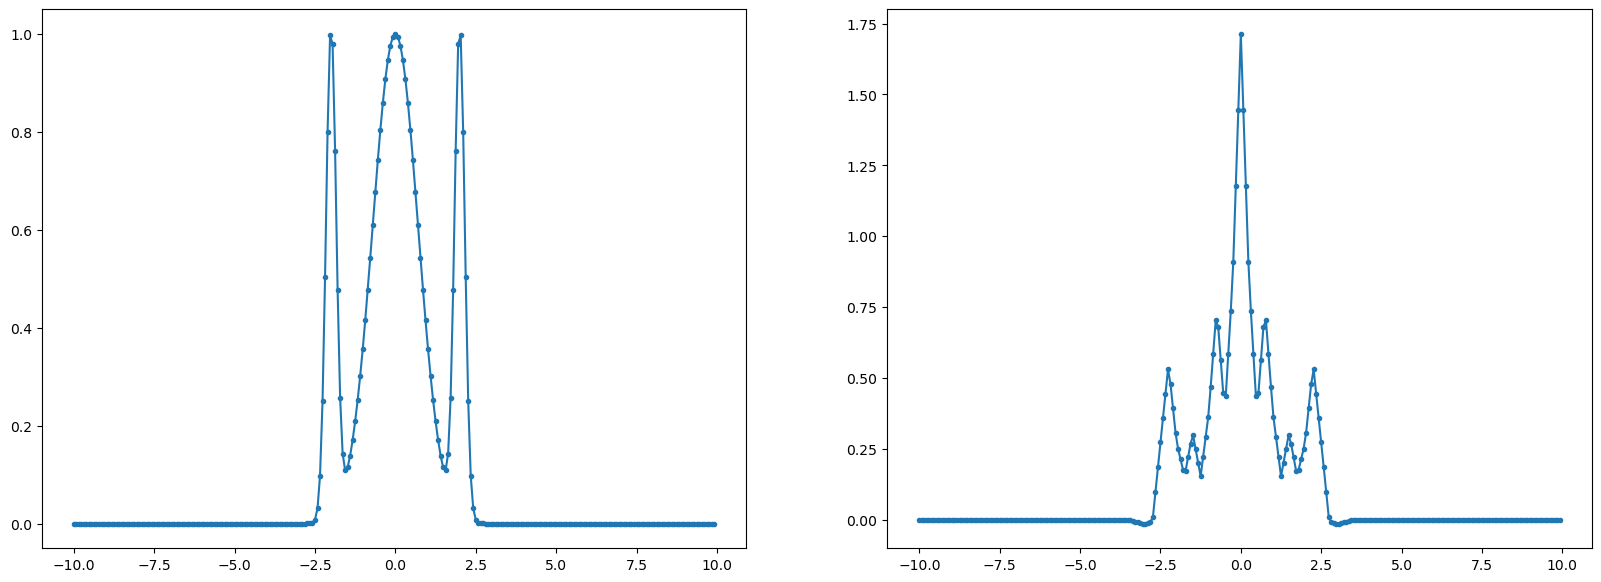

In [168]:
fig, ax = plt.subplots(1, 2, figsize=[20, 7])
target_slice = [slice(None, None), grid.shape[1]//2]
ax[0].plot(grid.x[target_slice].get(), target[target_slice].get(), '.-')
ax[1].plot(grid.x[target_slice].get(), decomposed_res[target_slice].get(), '.-')